In [1]:
import scipy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import pickle
import math

In [2]:
fDF = pd.read_csv('Data/featureTypes.txt', names=['featureID'])

In [3]:
print fDF.shape
print fDF['featureID'][0]
n = 10000
d = 3000

(3000, 1)
flavors raspberries cherries


In [4]:
trainDF = pd.read_csv('Data/trainData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
YDF = pd.read_csv('Data/trainLabels.txt', names = ['label'])
valXDF = pd.read_csv('Data/valData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
valYDF = pd.read_csv('Data/valLabels.txt', names = ['label'])
print trainDF.shape[0]

247847


In [5]:
W = np.random.uniform(low=0.0, high=1.0,size = (d,))
B = np.zeros(n)
print W.shape

(3000,)


In [6]:
trainDF[:5]

,instanceID,featureID,value
0,1,13,0.209
1,1,83,0.209
2,1,228,0.209
3,1,242,0.209
4,1,371,0.209


In [7]:
#tDF = csr_matrix(trainDF) 
#print tDF[:5]

In [8]:
#sdf = pd.SparseDataFrame(tDF)
#print sdf[:5]

In [9]:
# Will lead to negative index if re-running
trainDF['instanceID'] -= 1
trainDF['featureID'] -= 1
sMat = csr_matrix((trainDF['value'], (trainDF['featureID'], trainDF['instanceID'])))
valXDF['instanceID'] -= 1
valXDF['featureID'] -= 1
valX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
Y = YDF['label'].as_matrix().transpose()
#print Y.shape
valY = valYDF['label'].as_matrix().transpose()

In [10]:
#print sMat.shape
#print sMat.todense()

In [11]:
#print sMat[:2]

In [12]:
X = sMat.copy()
print X.shape

(3000, 10000)


In [13]:
def initLamda(X, Y):
    YNorm = Y - float(Y.sum())/((float)(Y.shape[0]))
    return 2 * ((X * YNorm).max())
    
print initLamda(X, Y)

896.6381332


In [14]:
#tX = X.copy()
#print tX
#tX.data **= 2
#tA = 2*tX.sum(axis = 1)
#print max(tA), min(tA)
#print tA

In [15]:
#t = X.copy()
#print t[0]
#print t[0].sum()
#t.data **= 2
#print t[0].sum()
#print t
#TA = 2*t.sum(axis = 1)
#print TA

In [16]:
# change this to convergence condition

def rmse(input1, input2):
    out = input1 - input2
    #print out
    out **= 2
    out /= len(out)
    error = out.sum()
    return math.sqrt(error)


class Lasso:
    def __init__(self, X, Y, W, B, Lamda):
        self.X = X.copy()
        self.Y = Y.copy()
        self.W = W #.copy()  # Remove this copy later
        self.B = B #.copy()
        t = X.copy()
        t.data **= 2
        self.A = 2*t.sum(axis = 1)
        self.Lamda = Lamda
        self.delta = 0.01
        # Stores Lamda and respective RMSE
        self.trainrmse = []
        self.trainlamda = []
        self.valrmse = []
        self.vallamda = []
        self.NonZero = []
        
    def loss(self):
        return ((self.X.transpose() * self.W + self.B - self.Y) ** 2).sum() + self.Lamda * (abs(self.W)).sum()
        
    def fit(self):
        # Lamda = initLamda(self.X, self.Y)
        
        #print X.shape, W.shape
        #for epoch in range(100):
        oldLoss = self.loss()+2
        newLoss = self.loss()
        print 'Lamda: ', self.Lamda
        while oldLoss - newLoss > self.delta:
            #print sMat.transpose() * W
            # 4.1.1
            #print t1[:5], t1.shape
            #print t1.shape, B.shape, Y.shape
            XTW = (self.X.transpose() * self.W)
            R = self.Y - (self.X.transpose() * self.W) - self.B
             
            # 4.1.2
            self.B = (R + self.B) / n 
            #self.B = (self.Y - XTW) / n
            #print B.shape
            # 4.1.3
            R = (n-1) * self.B
            #R = self.Y - (XTW + self.B)
            #print R.shape
            #print R[:5]
            # R = R.reshape(-1)
            for ik in range(0, d):
                # 4.1.4
                #ik = 0
                t = (self.X[ik].transpose() * self.W[ik]).toarray().reshape(-1)
                #print t
                #print t.shape
                #print R.shape
                Ck = (2 * self.X[ik] * (R + t)).sum()
                #Ck = (2 * self.X[ik] * (self.Y - self.B - t)).sum()
                #print Ck.sum()
                # Update Weight
                WkOld = self.W[ik]
                if Ck < -self.Lamda:
                    self.W[ik] = (Ck + self.Lamda) / self.A[ik]
                elif Ck > self.Lamda:
                    self.W[ik] = (Ck - self.Lamda) / self.A[ik]
                else:
                    self.W[ik] = 0
                #print W[ik]
                # 4.1.5
                # print self.W[ik], WkOld
                #print X[ik].toarray().reshape(-1).shape, R.shape
                R = R + self.X[ik].toarray().reshape(-1) * (WkOld - self.W[ik])
                #R = self.Y - (self.X.transpose() * self.W) + self.B
            oldLoss = newLoss
            newLoss = model.loss()
            #print oldLoss, newLoss, oldLoss - newLoss
            print 'LOSS:' , newLoss
            # End of feature vector iterator
    
    def saveModel(self, filename):
        pickle.dump(self, open( filename, "wb" ))
    
    def predict(self, X):
        return (X.transpose() * self.W + self.B)
    
    def chooseCorrectLamda(self, delta = -1, lowLam = 0.00002, highLam = 7.23414151):
        oldLamda = self.Lamda
        if delta != -1:
            self.delta = delta
        
        self.Lamda = lowLam
        self.fit()
        lowRMSE = rmse(self.predict(self.X), self.Y)
        
        self.Lamda = highLam
        self.fit()
        highRMSE = rmse(self.predict(self.X), self.Y)
        
        
        while lowLam < highLam:
            self.Lamda = (highLam-lowLam) / 2.0 + lowLam
            self.fit()
            midRMSE = rmse(self.predict(self.X), self.Y)
            print midRMSE, ' ' , lowRMSE, ' ', highRMSE    
            if (midRMSE > lowRMSE):
                highLam = self.Lamda
            elif (midRMSE < highLam):
                lowLam = self.Lamda
            else:
                return lowLam
            
            self.saveModel('optimal_saved_Model')
        return lowLam      
def loadModel(filename):
    return pickle.load(open(filename, "rb" ))

In [17]:
model = Lasso(X, Y, W, B, 2) # initLamda(X.copy(), Y.copy()))
#model.loss()
#model.fit()

In [18]:
print model.Lamda

2


In [19]:
print 'Least Lamda', model.chooseCorrectLamda()

Least Lamda Lamda:  2e-05
LOSS: 18683574.751
LOSS: 9753885.74132
LOSS: 6840489.96759
LOSS: 5299416.59398
LOSS: 4325680.03862
LOSS: 3650153.70857
LOSS: 3150036.74392
LOSS: 2762738.74024
LOSS: 2454067.25508
LOSS: 2203569.90055
LOSS: 1997758.13174
LOSS: 1826989.53216
LOSS: 1683991.12789
LOSS: 1563107.08352
LOSS: 1459869.52944
LOSS: 1370722.58005
LOSS: 1292828.80647
LOSS: 1223927.2657
LOSS: 1162227.031
LOSS: 1106325.55172
LOSS: 1055143.81118
LOSS: 1007872.29358
LOSS: 963923.724182
LOSS: 922890.246189
LOSS: 884504.112242
LOSS: 848601.81928
LOSS: 815092.096888
LOSS: 783928.258598
LOSS: 755085.328752
LOSS: 728542.113809
LOSS: 704268.13134
LOSS: 682215.050793
LOSS: 662312.125935
LOSS: 644464.975647
LOSS: 628556.996098
LOSS: 614452.697201
LOSS: 602002.290043
LOSS: 591046.930131
LOSS: 581424.107474
LOSS: 572972.775799
LOSS: 565537.917405
LOSS: 558974.340099
LOSS: 553149.581723
LOSS: 547945.889548
LOSS: 543261.291179
LOSS: 539009.840212
LOSS: 535121.136553
LOSS: 531539.264166
LOSS: 528221.286739


LOSS: 490463.887668
LOSS: 490463.667215
LOSS: 490463.447804
LOSS: 490463.229428
LOSS: 490463.012083
LOSS: 490462.795761
LOSS: 490462.580457
LOSS: 490462.366165
LOSS: 490462.152878
LOSS: 490461.940592
LOSS: 490461.7293
LOSS: 490461.518997
LOSS: 490461.309677
LOSS: 490461.101333
LOSS: 490460.893962
LOSS: 490460.687557
LOSS: 490460.482112
LOSS: 490460.277623
LOSS: 490460.074083
LOSS: 490459.871488
LOSS: 490459.669832
LOSS: 490459.46911
LOSS: 490459.269316
LOSS: 490459.070446
LOSS: 490458.872494
LOSS: 490458.675455
LOSS: 490458.479324
LOSS: 490458.284096
LOSS: 490458.089766
LOSS: 490457.896329
LOSS: 490457.70378
LOSS: 490457.512115
LOSS: 490457.321328
LOSS: 490457.131414
LOSS: 490456.94237
LOSS: 490456.754189
LOSS: 490456.566868
LOSS: 490456.380402
LOSS: 490456.194786
LOSS: 490456.010016
LOSS: 490455.826086
LOSS: 490455.642994
LOSS: 490455.460733
LOSS: 490455.2793
LOSS: 490455.09869
LOSS: 490454.918899
LOSS: 490454.739922
LOSS: 490454.561756
LOSS: 490454.384396
LOSS: 490454.207837
LOSS: 49

LOSS: 490422.127544
LOSS: 490422.090869
LOSS: 490422.054351
LOSS: 490422.017987
LOSS: 490421.981779
LOSS: 490421.945724
LOSS: 490421.909822
LOSS: 490421.874073
LOSS: 490421.838476
LOSS: 490421.803031
LOSS: 490421.767736
LOSS: 490421.732591
LOSS: 490421.697595
LOSS: 490421.662748
LOSS: 490421.628049
LOSS: 490421.593498
LOSS: 490421.559094
LOSS: 490421.524835
LOSS: 490421.490723
LOSS: 490421.456755
LOSS: 490421.422932
LOSS: 490421.389252
LOSS: 490421.355716
LOSS: 490421.322322
LOSS: 490421.28907
LOSS: 490421.255959
LOSS: 490421.222989
LOSS: 490421.190159
LOSS: 490421.157469
LOSS: 490421.124918
LOSS: 490421.092505
LOSS: 490421.060229
LOSS: 490421.028091
LOSS: 490420.996089
LOSS: 490420.964224
LOSS: 490420.932493
LOSS: 490420.900898
LOSS: 490420.869437
LOSS: 490420.838109
LOSS: 490420.806915
LOSS: 490420.775853
LOSS: 490420.744923
LOSS: 490420.714124
LOSS: 490420.683457
LOSS: 490420.652919
LOSS: 490420.622512
LOSS: 490420.592233
LOSS: 490420.562083
LOSS: 490420.532062
LOSS: 490420.502167
L

LOSS: 760884.093887
LOSS: 760883.924724
LOSS: 760883.76938
LOSS: 760883.626418
LOSS: 760883.494534
LOSS: 760883.372546
LOSS: 760883.25939
LOSS: 760883.154117
LOSS: 760883.055883
LOSS: 760882.963941
LOSS: 760882.877639
LOSS: 760882.796405
LOSS: 760882.719745
LOSS: 760882.64723
LOSS: 760882.57849
LOSS: 760882.513203
LOSS: 760882.451095
LOSS: 760882.391919
LOSS: 760882.335463
LOSS: 760882.281535
LOSS: 760882.22996
LOSS: 760882.18058
LOSS: 760882.13325
LOSS: 760882.087838
LOSS: 760882.044219
LOSS: 760882.002277
LOSS: 760881.961906
LOSS: 760881.923006
LOSS: 760881.885484
LOSS: 760881.849256
LOSS: 760881.814245
LOSS: 760881.780379
LOSS: 760881.747593
LOSS: 760881.71583
LOSS: 760881.685037
LOSS: 760881.655164
LOSS: 760881.626168
LOSS: 760881.598007
LOSS: 760881.570643
LOSS: 760881.544043
LOSS: 760881.518171
LOSS: 760881.492997
LOSS: 760881.468491
LOSS: 760881.444624
LOSS: 760881.42137
LOSS: 760881.398703
LOSS: 760881.376598
LOSS: 760881.355033
LOSS: 760881.333986
LOSS: 760881.313437
LOSS: 760

LOSS: 530716.622462
LOSS: 530716.189685
LOSS: 530715.769487
LOSS: 530715.361291
LOSS: 530714.964765
LOSS: 530714.57973
LOSS: 530714.205318
LOSS: 530713.840996
LOSS: 530713.486348
LOSS: 530713.140997
LOSS: 530712.80459
LOSS: 530712.476794
LOSS: 530712.157292
LOSS: 530711.845784
LOSS: 530711.541987
LOSS: 530711.245629
LOSS: 530710.956451
LOSS: 530710.674206
LOSS: 530710.398657
LOSS: 530710.129577
LOSS: 530709.866749
LOSS: 530709.609962
LOSS: 530709.359015
LOSS: 530709.113715
LOSS: 530708.873877
LOSS: 530708.639561
LOSS: 530708.410477
LOSS: 530708.186365
LOSS: 530707.967043
LOSS: 530707.75235
LOSS: 530707.542142
LOSS: 530707.33628
LOSS: 530707.134636
LOSS: 530706.937087
LOSS: 530706.743514
LOSS: 530706.553807
LOSS: 530706.367857
LOSS: 530706.185562
LOSS: 530706.006826
LOSS: 530705.831553
LOSS: 530705.659656
LOSS: 530705.491048
LOSS: 530705.325649
LOSS: 530705.163378
LOSS: 530705.004162
LOSS: 530704.847927
LOSS: 530704.694604
LOSS: 530704.544125
LOSS: 530704.396426
LOSS: 530704.251445
LOSS

LOSS: 511005.901152
LOSS: 511005.874098
LOSS: 511005.847192
LOSS: 511005.820434
LOSS: 511005.793822
LOSS: 511005.767354
LOSS: 511005.741029
LOSS: 511005.714847
LOSS: 511005.688806
LOSS: 511005.662905
LOSS: 511005.637143
LOSS: 511005.611519
LOSS: 511005.586032
LOSS: 511005.56068
LOSS: 511005.535462
LOSS: 511005.510378
LOSS: 511005.485427
LOSS: 511005.460607
LOSS: 511005.435918
LOSS: 511005.411357
LOSS: 511005.386926
LOSS: 511005.362621
LOSS: 511005.338444
LOSS: 511005.314392
LOSS: 511005.290464
LOSS: 511005.26666
LOSS: 511005.242979
LOSS: 511005.21942
LOSS: 511005.195982
LOSS: 511005.172663
LOSS: 511005.149464
LOSS: 511005.126384
LOSS: 511005.103421
LOSS: 511005.080574
LOSS: 511005.057844
LOSS: 511005.035228
LOSS: 511005.012727
LOSS: 511004.990339
LOSS: 511004.968063
LOSS: 511004.945899
LOSS: 511004.923847
LOSS: 511004.901905
LOSS: 511004.880072
LOSS: 511004.858348
LOSS: 511004.836732
LOSS: 511004.815223
LOSS: 511004.793821
LOSS: 511004.772524
LOSS: 511004.751333
LOSS: 511004.730246
LOS

LOSS: 500838.401668
LOSS: 500838.365737
LOSS: 500838.329991
LOSS: 500838.294428
LOSS: 500838.259047
LOSS: 500838.223847
LOSS: 500838.188824
LOSS: 500838.153979
LOSS: 500838.11931
LOSS: 500838.084816
LOSS: 500838.050495
LOSS: 500838.016345
LOSS: 500837.982366
LOSS: 500837.948555
LOSS: 500837.914913
LOSS: 500837.881437
LOSS: 500837.848127
LOSS: 500837.81498
LOSS: 500837.781996
LOSS: 500837.749174
LOSS: 500837.716513
LOSS: 500837.68401
LOSS: 500837.651666
LOSS: 500837.619478
LOSS: 500837.587447
LOSS: 500837.55557
LOSS: 500837.523846
LOSS: 500837.492276
LOSS: 500837.460856
LOSS: 500837.429587
LOSS: 500837.398468
LOSS: 500837.367497
LOSS: 500837.336673
LOSS: 500837.305996
LOSS: 500837.275464
LOSS: 500837.245076
LOSS: 500837.214832
LOSS: 500837.18473
LOSS: 500837.15477
LOSS: 500837.124951
LOSS: 500837.095271
LOSS: 500837.06573
LOSS: 500837.036327
LOSS: 500837.007062
LOSS: 500836.977932
LOSS: 500836.948938
LOSS: 500836.920078
LOSS: 500836.891352
LOSS: 500836.862759
LOSS: 500836.834298
LOSS: 5

LOSS: 495660.318426
LOSS: 495660.289941
LOSS: 495660.261704
LOSS: 495660.233711
LOSS: 495660.205957
LOSS: 495660.178437
LOSS: 495660.151146
LOSS: 495660.124081
LOSS: 495660.097237
LOSS: 495660.070611
LOSS: 495660.044197
LOSS: 495660.017992
LOSS: 495659.991994
LOSS: 495659.966197
LOSS: 495659.940599
LOSS: 495659.915196
LOSS: 495659.889985
LOSS: 495659.864963
LOSS: 495659.840127
LOSS: 495659.815474
LOSS: 495659.791001
LOSS: 495659.766705
LOSS: 495659.742583
LOSS: 495659.718634
LOSS: 495659.694853
LOSS: 495659.67124
LOSS: 495659.647791
LOSS: 495659.624503
LOSS: 495659.601376
LOSS: 495659.578406
LOSS: 495659.555592
LOSS: 495659.53293
LOSS: 495659.51042
LOSS: 495659.488059
LOSS: 495659.465845
LOSS: 495659.443777
LOSS: 495659.421852
LOSS: 495659.400068
LOSS: 495659.378424
LOSS: 495659.356917
LOSS: 495659.335548
LOSS: 495659.314312
LOSS: 495659.29321
LOSS: 495659.272239
LOSS: 495659.251397
LOSS: 495659.230684
LOSS: 495659.210098
LOSS: 495659.189636
LOSS: 495659.169299
LOSS: 495659.149084
LOSS

LOSS: 491733.54197
LOSS: 491733.51609
LOSS: 491733.490875
LOSS: 491733.466287
LOSS: 491733.442292
LOSS: 491733.418859
LOSS: 491733.395958
LOSS: 491733.37356
LOSS: 491733.351641
LOSS: 491733.330176
LOSS: 491733.309143
LOSS: 491733.28852
LOSS: 491733.268289
LOSS: 491733.24843
LOSS: 491733.228927
LOSS: 491733.209763
LOSS: 491733.190924
LOSS: 491733.172396
LOSS: 491733.154166
LOSS: 491733.136221
LOSS: 491733.118549
LOSS: 491733.101141
LOSS: 491733.083986
LOSS: 491733.067073
LOSS: 491733.050396
LOSS: 491733.033943
LOSS: 491733.017709
LOSS: 491733.001684
LOSS: 491732.985862
LOSS: 491732.970235
LOSS: 491732.954798
LOSS: 491732.939543
LOSS: 491732.924466
LOSS: 491732.909559
LOSS: 491732.894818
LOSS: 491732.880237
LOSS: 491732.865812
LOSS: 491732.851537
LOSS: 491732.837409
LOSS: 491732.823423
LOSS: 491732.809574
LOSS: 491732.79586
LOSS: 491732.782275
LOSS: 491732.768817
LOSS: 491732.755483
LOSS: 491732.742268
LOSS: 491732.72917
LOSS: 491732.716186
LOSS: 491732.703314
LOSS: 491732.69055
LOSS: 49

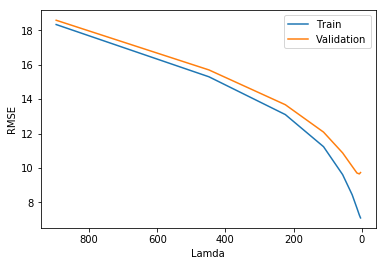

In [20]:
import matplotlib.pyplot as plt
plt.plot(model.trainlamda, model.trainrmse)
plt.plot(model.vallamda, model.valrmse)
plt.ylabel('RMSE')
plt.xlabel('Lamda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('RMSEvsLamda.png')

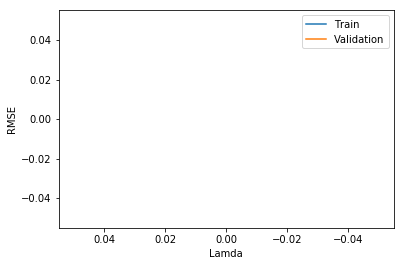

In [20]:
import matplotlib.pyplot as plt
plt.plot(model.trainlamda, model.trainrmse)
plt.plot(model.vallamda, model.valrmse)
plt.ylabel('RMSE')
plt.xlabel('Lamda')
ax = plt.gca()
ax.invert_xaxis()
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('RMSEvsLamda.png')

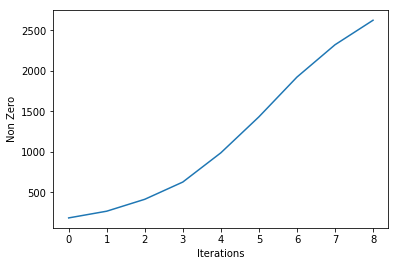

In [21]:
import matplotlib.pyplot as plt
plt.plot(model.NonZero)
plt.ylabel('Non Zero')
plt.xlabel('Iterations')
#plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
#plt.savefig('NonZeroElements.png')

In [41]:
model.saveModel('savedModel')

In [21]:
print rmse(model.predict(valX), valY)
print rmse(X.transpose() * model.W, valY)
print model.predict(valX)
print valY

10.0555048996
8.72069593338
[ 106.19632726   91.43169694   89.94958837 ...,   85.2341356    87.54110808
   86.44698698]
[92 90 86 ..., 92 89 88]


In [28]:
testXDF = pd.read_csv('Data/testData.txt', names = ['instanceID', 'featureID', 'value'], sep=' ')
testX = csr_matrix((valXDF['value'], (valXDF['featureID'], valXDF['instanceID'])))
testPredicted = model.predict(testX)
print testPredicted
np.savetxt("out.csv", testPredicted, delimiter=",")
#testPredicted.to_csv('out.csv')

[ 105.71206656   85.54415933   87.60385796 ...,   87.82942353   87.01643808
   85.78716094]
